# Calculating the LSD profiles

## 0 Packages and data

In [1]:
%cd /content

/content


In [2]:
!git clone https://github.com/folsomcp/specpolFlow

Cloning into 'specpolFlow'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 375 (delta 18), reused 25 (delta 9), pack-reused 338
Receiving objects: 100% (375/375), 6.32 MiB | 12.09 MiB/s, done.
Resolving deltas: 100% (163/163), done.


In [3]:
!git clone https://github.com/folsomcp/LSDpy

Cloning into 'LSDpy'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 44 (delta 23), reused 25 (delta 11), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [4]:
%cd /content/LSDpy
!ls
import lsdpy
%cd /content

/content/LSDpy
hd219134_19jun16_v_01.spec  LICENSE	 lsdpy.py		     README.md
inlsd.dat		    lsdpFunc.py  mask-4500g40-0.1-trim3.dat
/content


In [5]:
import specpolFlow as pol
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

loading specpolFlow package


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
cd /content/drive/Shareddrives/BeStarsMiMeS/

/content/drive/Shareddrives/BeStarsMiMeS


In [12]:
path = '/content/drive/Shareddrives/BeStarsMiMeS'

In [8]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd

In [9]:
gc = gspread.authorize(creds)
spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1M6y1Wnsrc-w5FjUMfKaSFa_-foIDAaMe8W4lYNWnWyk/edit?usp=sharing')

worksheet = spreadsheet.worksheet("Stars")
rows  = worksheet.get_all_records()

StarData = pd.DataFrame.from_records(rows)  

worksheet = spreadsheet.worksheet("Observations")
rows  = worksheet.get_all_records()

Observations = pd.DataFrame.from_records(rows)

In [10]:
import itertools

### This gets rid of the warnings in the cells where it is creating more than 20 figures (i.e. 1.2)
#### Not needed for this notebook but could be useful in the future
#import warnings
#warnings.filterwarnings("default", message="More than 20 figures have been opened.")


## Graph of line masks for comparison.

There is also a table in Pandas format at the end, to compare the numerical values



In [32]:
#hd = 'hd148184' # A star with a lot of emission
hd = 'hd189687' # A well behaved star
star = StarData[StarData["Name"]==hd]

obs = Observations[Observations["Name"] == hd]

o = 1
ob = obs[obs["ObsOrder"]==o]

star
ob

modelcode = star["ModelCode"].item().upper()
maskUS = path+'/02-Mask-calculations/MaskCleaning/depth0.02_tellClean/{}_depth0.02.mask'.format(modelcode)
maskAsifClean = path+'/00-InputMaterial/AsifMaskClean/{}_clean_{}.mask'.format(hd,o)
maskAsifCleanTweak = path+'/00-InputMaterial/AsifMaskCleanTweak/{}_clean_{}.mask_auto_twk'.format(hd,o)

synth_name = path+'/01-Synth-calculations/Synth-hybrid-spectra/{}_{}_noise.s'.format(hd, o)
obs_name = path+'/00-InputMaterial/NormalizedSpectra/{}_{}.s'.format(hd, o)

mk_AsifClean = pol.iolsd.mask(fname=maskAsifClean)
mk_AsifCleanTweak = pol.iolsd.mask(fname=maskAsifCleanTweak)
mk_US = pol.iolsd.mask(fname=maskUS)

spec_obs = pol.iolsd.read_spectrum(obs_name)
spec_synth = pol.iolsd.read_spectrum(synth_name)

,HD,Name,Nobs,T,log(g),ModelCode,Adopted-vsini,Halpha shape,Notes,
59,189687,hd189687,1,18000,4.0,T19000g40,280.0,asymetric shell,,


,F,HDOrder,ObsOrder,Name,LSDfileName,NameAsif,NameOfMask,HarpsFlag,NameOfSymbolicLinkToData,vsiniMean_dep,vrad,vradCorrected
145,85,59,1,hd189687,hd189687_1.lsd.s,hd189687_1,mask_T18000g40lamb3700_9000.dat,0,hd189687_10BP14_1217880pnv.s,359.51,-14.659473,-14.659473


Text(0, 0.5, 'depth')

Text(0.5, 0, 'Wave (nm)')

(0.0, 0.4)

(441.0, 445.0)

(0.9, 1.1)

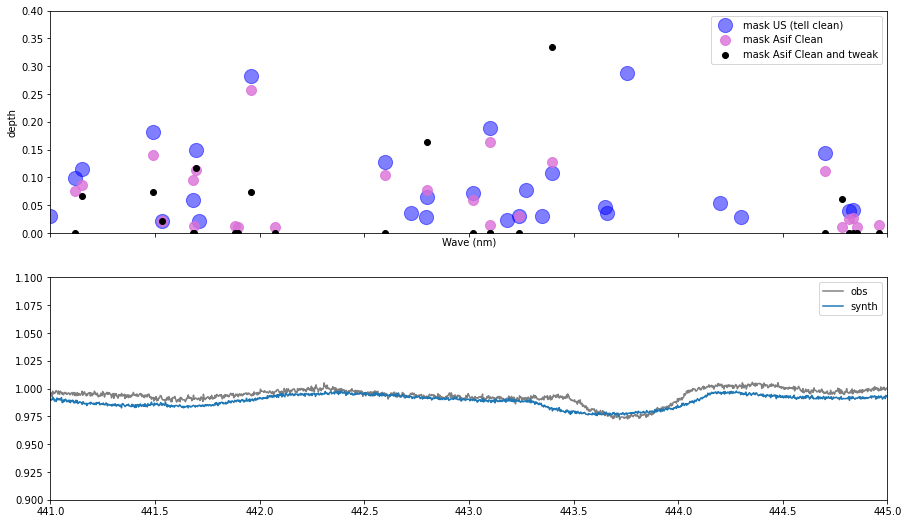

In [61]:
fig, ax = plt.subplots(2,1, figsize=(15,9), sharex=True)
ax[0].set_ylabel('depth')
ax[0].set_xlabel('Wave (nm)')
n = mk_US.iuse == 1
ax[0].scatter(mk_US.wl[n], mk_US.depth[n], label='mask US (tell clean)', s=200, alpha=0.5, c='blue')

n = mk_AsifClean.iuse == 1
ax[0].scatter(mk_AsifClean.wl[n], mk_AsifClean.depth[n], label='mask Asif Clean', s=100, alpha=0.8, c='orchid')

n = mk_AsifClean.iuse == 1
ax[0].scatter(mk_AsifCleanTweak.wl[n], mk_AsifCleanTweak.depth[n], label='mask Asif Clean and tweak', c='k')

ax[0].legend(loc=0)
ax[0].set_ylim(0,0.4)
#ax[0].set_xlim(420,455)
ax[0].set_xlim(441,445)

ax[1].plot(spec_obs.wl, spec_obs.specI, c='0.5', label='obs')
ax[1].plot(spec_synth.wl, spec_synth.specI, label='synth')
ax[1].legend(loc=0)
ax[1].set_ylim(0.9,1.1)

In [62]:
import pandas as pd

n = mk_US.wl>=441
nA = mk_AsifClean.wl >=441
nAT = mk_AsifCleanTweak.wl >=441

t = 15

dic = {
       'US wl':mk_US.wl[n][0:t],
       'US el':mk_US.element[n][0:t],
       'US d':mk_US.depth[n][0:t],
       'US iuse':mk_US.iuse[n][0:t],
       'A wl':mk_AsifClean.wl[nA][0:t],
       'A el':mk_AsifClean.element[nA][0:t],
       'A d':mk_AsifClean.depth[nA][0:t],
       'A iuse':mk_AsifClean.iuse[nA][0:t],
       'AT wl':mk_AsifCleanTweak.wl[nA][0:t],
       'AT el':mk_AsifCleanTweak.element[nA][0:t],
       'AT d':mk_AsifCleanTweak.depth[nA][0:t],
       'AT iuse':mk_AsifCleanTweak.iuse[nA][0:t]

       }
toto = pd.DataFrame(dic)


In [63]:
toto

,US wl,US el,US d,US iuse,A wl,A el,A d,A iuse,AT wl,AT el,AT d,AT iuse
0,441.1152,6.01,0.099,1,441.0210,26.01,0.015,0,441.0210,26.01,0.0150,0
1,441.1510,6.01,0.115,1,441.1152,6.01,0.075,1,441.1152,6.01,0.0000,1
2,441.4905,8.01,0.181,1,441.1510,6.01,0.087,1,441.1510,6.01,0.0660,1
3,441.5339,16.01,0.022,1,441.4905,8.01,0.141,1,441.4905,8.01,0.0745,1
4,441.6819,26.01,0.060,1,441.5339,16.01,0.022,1,441.5339,16.01,0.0210,1
5,441.6974,8.01,0.150,1,441.6819,26.01,0.096,1,441.6819,26.01,0.0000,1
6,441.7100,7.01,0.021,1,441.6864,16.01,0.012,1,441.6864,16.01,0.0000,1
7,441.9596,26.02,0.283,1,441.6974,8.01,0.114,1,441.6974,8.01,0.1172,1
8,442.6001,18.01,0.128,1,441.8836,16.02,0.013,1,441.8836,16.02,0.0000,1
9,442.7233,7.01,0.036,1,441.8941,26.01,0.011,1,441.8941,26.01,0.0000,1


## Histogram of line depths

In [87]:
#hd = 'hd148184' # A star with a lot of emission
hd = 'hd189687' # A well behaved star
star = StarData[StarData["Name"]==hd]

obs = Observations[Observations["Name"] == hd]

o = 1
ob = obs[obs["ObsOrder"]==o]

star
ob

modelcode = star["ModelCode"].item().upper()
maskUS = path+'/02-Mask-calculations/MaskCleaning/depth0.02_tellClean/{}_depth0.02.mask'.format(modelcode)
maskAsifClean = path+'/00-InputMaterial/AsifMaskClean/{}_clean_{}.mask'.format(hd,o)
maskAsifCleanTweak = path+'/00-InputMaterial/AsifMaskCleanTweak/{}_clean_{}.mask_auto_twk'.format(hd,o)

synth_name = path+'/01-Synth-calculations/Synth-hybrid-spectra/{}_{}_noise.s'.format(hd, o)
obs_name = path+'/00-InputMaterial/NormalizedSpectra/{}_{}.s'.format(hd, o)

mk_AsifClean = pol.iolsd.mask(fname=maskAsifClean)
mk_AsifCleanTweak = pol.iolsd.mask(fname=maskAsifCleanTweak)
mk_US = pol.iolsd.mask(fname=maskUS)

,HD,Name,Nobs,T,log(g),ModelCode,Adopted-vsini,Halpha shape,Notes,
59,189687,hd189687,1,18000,4.0,T19000g40,280.0,asymetric shell,,


,F,HDOrder,ObsOrder,Name,LSDfileName,NameAsif,NameOfMask,HarpsFlag,NameOfSymbolicLinkToData,vsiniMean_dep,vrad,vradCorrected
145,85,59,1,hd189687,hd189687_1.lsd.s,hd189687_1,mask_T18000g40lamb3700_9000.dat,0,hd189687_10BP14_1217880pnv.s,359.51,-14.659473,-14.659473


Text(0.5, 1.0, 'hd189687')

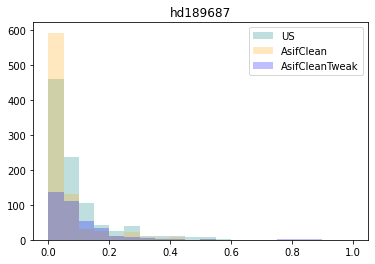

In [88]:
fig, ax = plt.subplots(1,1)

h=ax.hist(mk_US.depth[mk_US.iuse==1], label='US', range=[0,1], bins=20, fc='teal', alpha=0.25)
h=ax.hist(mk_AsifClean.depth[mk_AsifClean.iuse==1], alpha=0.25, label='AsifClean', range=[0,1], bins=20, fc='orange')
h=ax.hist(mk_AsifCleanTweak.depth[np.logical_and(mk_AsifCleanTweak.iuse==1,mk_AsifCleanTweak.depth>=0.0001)], 
          label='AsifCleanTweak', range=[0,1], bins=20, fc='blue', alpha=0.25)

ax.legend(loc=0)
ax.set_title(hd)